In [52]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import requests
import QuantLib as ql
import numpy as np
import json
from tradingview_screener import Query, col
import rookiepy
from sklearn.preprocessing import MinMaxScaler
import gbm_optimizer
from gbm_optimizer import optimize_gbm, gbm
import matplotlib.pyplot as plt
from arch import arch_model
from yahooquery import Ticker


import importlib
importlib.reload(gbm_optimizer)


with open("config.json", "r") as config_file:
    config = json.load(config_file)

api_key = config.get("api_key")
secret_key = config.get("secret_key")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

our_picks = ["CHWY", "IBIT", "ASO", "MARA", "ET", "DVN", "INTC", "SPLG", "TOST", "NBIS"]
too_expensive = ["HIMS", "TEM"]


In [58]:
    
def screen_stocks():
    # Get cookies for TradingView session
    cookies = rookiepy.to_cookiejar(rookiepy.chrome(['.tradingview.com']))
    
    _, df = Query().select('close','change', 'Perf.3M', 'Perf.6M').where(
        col('close').between(15, 30),
        col('change').between(-4,-2),
        col('Perf.3M') > 0,
        col('Perf.6M') > 5,
        col('exchange').isin(['AMEX', 'NASDAQ', 'NYSE']),

        ).limit(1000).get_scanner_data(cookies=cookies)
    
    df[['exchange', 'ticker']] = df['ticker'].str.split(':', expand=True)
    
    return df


def get_current_stock_price(symbol: str):

    url = "https://data.alpaca.markets/v2/stocks/trades/latest"

    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": api_key,
        "APCA-API-SECRET-KEY": secret_key,
    }

    params = {
        "symbols": symbol,  
        "feed": "iex" 
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  

        data = response.json()

        return data.get("trades", {}).get(symbol, {}).get("p") 

    except requests.exceptions.RequestException as e:
        print(f"Error fetching stock price: {e}")



def get_option_chain(symbol, option_type="puts", expiration_date=None):
    """
    Fetches the option chain for a given stock symbol using yahooquery.

    :param symbol: Stock ticker symbol (e.g., "AAPL").
    :param option_type: 'calls', 'puts', or None (default: both calls and puts).
    :param expiration_date: Specific expiration date (e.g., '2025-03-21') or None to get all available expirations.
    :return: pandas DataFrame containing the option chain.
    """
    try:
        stock = Ticker(symbol)
        df = stock.option_chain  # Fetch all available option chain data

        if df is None or df.empty:
            print(f"No option data available for {symbol}.")
            return None

        # Filter by expiration date if provided
        if expiration_date:
            df = df.loc[df.index.get_level_values('expiration') == expiration_date]

        # Filter by option type if provided ('calls' or 'puts')
        if option_type in ['calls', 'puts']:
            df = df.xs(option_type, level=2)

        # Reset index to remove multi-indexing
        df = df.reset_index()

        # Rename 'expiration' to 'expiration_date'
        df = df.rename(columns={'expiration': 'expiration_date'})

        # Calculate ROI as (bid + ask) / strike * 100
        df['mid_price'] = (df['bid'] + df['ask']) / 2
        df['ROI'] = (df['mid_price'] / df['strike']) * 100
        

        # Filter rows based on open interest, bid, in-the-money, and ROI
        df = df[(df['openInterest'] >= 50) & 
                (df['bid'] > 0.00) & 
                (df['inTheMoney'] != True) & 
                (df['ROI'] <= 4.0) & 
                (df['ROI'] > 0.1) &
                (((df['ask'] - df['bid']) / df['bid']) * 100 < 40)
                ] 

        return df

    except Exception as e:
        print(f"Error fetching option chain: {e}")
        return None


def select_optimal_contract(contracts):
    """Compute the weighted score for contracts using normalized values."""
    temp_contracts = contracts.copy()
    
    scaler = MinMaxScaler()
    temp_contracts[['profitability_likelihood', 'ROI', 'sortino_ratio']] = scaler.fit_transform(
        temp_contracts[['profitability_likelihood', 'ROI', 'sortino_ratio']]
    )
    
    temp_contracts['score'] = (
        0.60 * temp_contracts['profitability_likelihood'] +
        0.40 * temp_contracts['ROI'] +
        0.10 * temp_contracts['sortino_ratio']
    )
    
    contracts['score'] = temp_contracts['score']
    
    return contracts.sort_values(by='score', ascending=False)


def audit_stocks(expiration_date: datetime, tickers: list = None):

    all_options = []

    # Determine which stocks to audit
    if tickers is None or not tickers:
        tickers = screen_stocks()['ticker'].to_list()
        tickers.extend(our_picks)

    print(f"Auditing {len(tickers)} stocks: {tickers}")

    for ticker in tickers:
        put_chain = audit_single_ticker(ticker=ticker, expiration_date=expiration_date)
        if not put_chain.empty:
            all_options.append(put_chain)

    # Combine all results into a single DataFrame
    if all_options:
        result_df = pd.concat(all_options, ignore_index=True)
        return result_df

    return pd.DataFrame()


def audit_single_ticker(ticker: str, expiration_date: datetime):
    # T-bill 3-month rate: 4.19%, scaled to daily compounding
    daily_risk_free_rate = (1 + 0.0419) ** (1/252) - 1

    simulation_attempts = 300
    optimizer_training_period = "6mo"
    bin_length = 18
    days_to_expiration = np.busday_count(datetime.today().date(), expiration_date.date())

    option_chain = get_option_chain(symbol=ticker, expiration_date=expiration_date)

    if option_chain is None or option_chain.empty:
        print(f"No options available for {ticker} on {expiration_date}")
        return pd.DataFrame()

    price = get_current_stock_price(ticker)

    optimized_mu, optimized_sigma = optimize_gbm(symbol=ticker, training_period=optimizer_training_period, bin_length=bin_length)
    optimized_sigma = fit_garch(symbol=ticker, period=optimizer_training_period)

    gbm_vs_real_graph(symbol=ticker, mu=optimized_mu, sigma=optimized_sigma, period=optimizer_training_period)

    put_chain = option_chain.copy()

    for index, contract in put_chain.iterrows():
        strike_price = contract['strike']
        mid_price = (contract['bid'] + contract['ask']) / 2
        simulated_returns = []
        simulated_final_prices = []
        profitable_count = 0

        for _ in range(simulation_attempts):
            prices = gbm(s0=price, mu=optimized_mu, sigma=optimized_sigma, deltaT=days_to_expiration, dt=1)
            final_price = prices[-1]

            # Option expires worthless or at-the-money
            if final_price >= strike_price:
                profitable_count += 1
                net_return = (mid_price / strike_price) * 100
            else:
                # Assigned: premium - (loss from assignment)
                net_return = ((mid_price - (strike_price - final_price)) / strike_price) * 100

            simulated_returns.append(net_return)
            simulated_final_prices.append(final_price)

        profitability_chance = (profitable_count / simulation_attempts) * 100
        avg_return = np.mean(simulated_returns)
        avg_price = np.mean(simulated_final_prices)
        risk_free_return = daily_risk_free_rate * days_to_expiration

        downside_returns = [r for r in simulated_returns if r < risk_free_return]
        downside_std = np.std(downside_returns, ddof=1) if len(downside_returns) > 1 else 0

        sortino_ratio = ((avg_return - risk_free_return) / downside_std) * np.sqrt(252 / days_to_expiration) if downside_std else 0

        put_chain.at[index, 'current_price'] = price
        put_chain.at[index, 'final_price'] = avg_price
        put_chain.at[index, 'profitability_likelihood'] = profitability_chance
        put_chain.at[index, 'average_roi'] = avg_return
        put_chain.at[index, 'sortino_ratio'] = sortino_ratio

    put_chain.drop(columns=['inTheMoney','contractSymbol','currency','contractSize', 'lastTradeDate', 'impliedVolatility'], errors='ignore', inplace=True)

    return put_chain


def fit_garch(symbol, period):
    stock_data = yf.download(symbol, period=period, interval="1d", progress=False, auto_adjust=False)
    real_prices = stock_data["Close"].dropna().values.flatten()
    returns = np.diff(np.log(real_prices))
    
    # Fit GARCH(1,1) model
    model = arch_model(returns, vol='Garch', p=1, q=1, rescale=False)
    garch_fit = model.fit(disp="off")
    
    conditional_volatilities = garch_fit.conditional_volatility

    N = len(conditional_volatilities)
    weights = np.linspace(1, 2, N)  

    weighted_volatility = np.sum(weights * conditional_volatilities) / np.sum(weights)

    return weighted_volatility

def gbm_vs_real_graph(symbol, mu, sigma, period):
    stock_data = yf.download(symbol, period=period, interval="1d", progress=False)
    real_prices = stock_data["Close"].dropna().values
    time_steps = np.arange(len(real_prices))


    gbm_path = gbm(s0 = real_prices[0], mu=mu, sigma=sigma, deltaT=len(real_prices), dt=1)
    plt.figure(figsize=(10, 5))
    plt.plot(time_steps, real_prices, label="Real Prices", color="blue")
    plt.plot(time_steps, gbm_path, label="GBM Simulated", linestyle="dashed", color="red")
    
    plt.xlabel("Time (Days)")
    plt.ylabel("Price")
    plt.title(f"GBM vs Real Prices for {symbol}")
    plt.legend()
    plt.grid()
    plt.show()



Auditing 55 stocks: ['SOFI', 'BILI', 'MBLY', 'MT', 'SAIL', 'PENN', 'DB', 'MP', 'MGNI', 'NVST', 'RSI', 'GRND', 'WEAV', 'EPOL', 'DAN', 'MAG', 'CAE', 'CLPT', 'FARO', 'UBRL', 'DSP', 'FWRG', 'OPRA', 'PRO', 'CCSI', 'PRAA', 'IIIV', 'DCTH', 'CTRN', 'MESO', 'TIL', 'IPX', 'FOA', 'SSTI', 'CVKD', 'HDL', 'FLGR', 'ESSA', 'DTAN', 'FET', 'GOCO', 'TISI', 'NBCE', 'CHWY', 'IBIT', 'ASO', 'MARA', 'TEM', 'HIMS', 'ET', 'DVN', 'INTC', 'SPLG', 'TOST', 'NBIS']


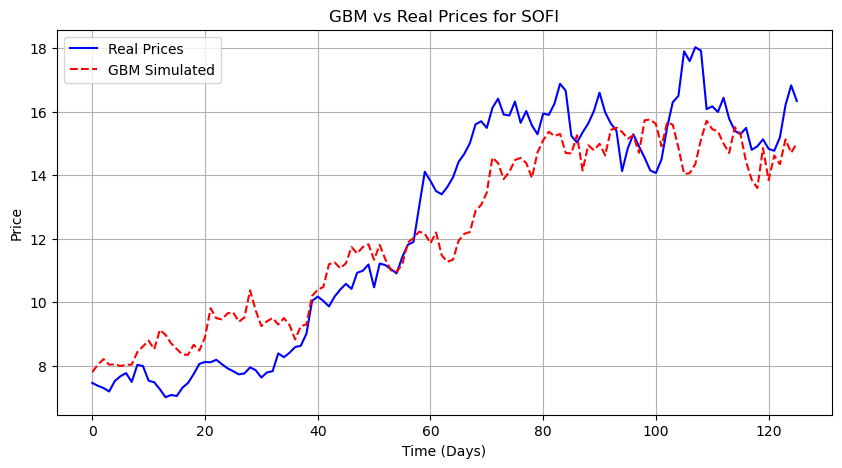

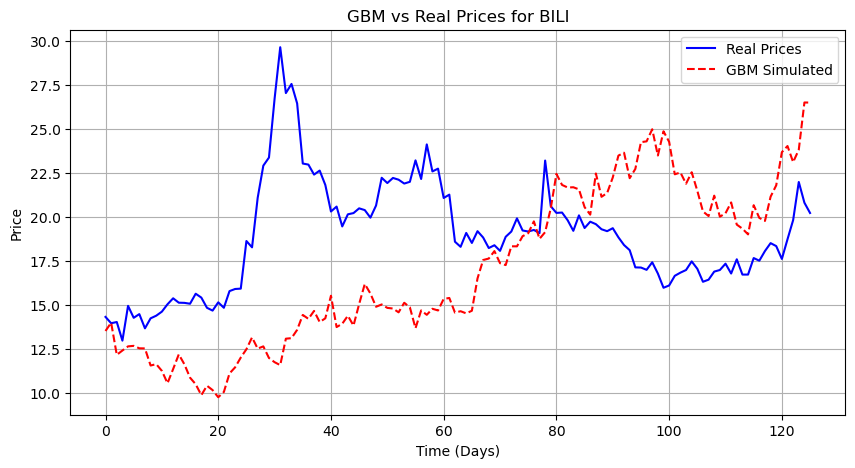

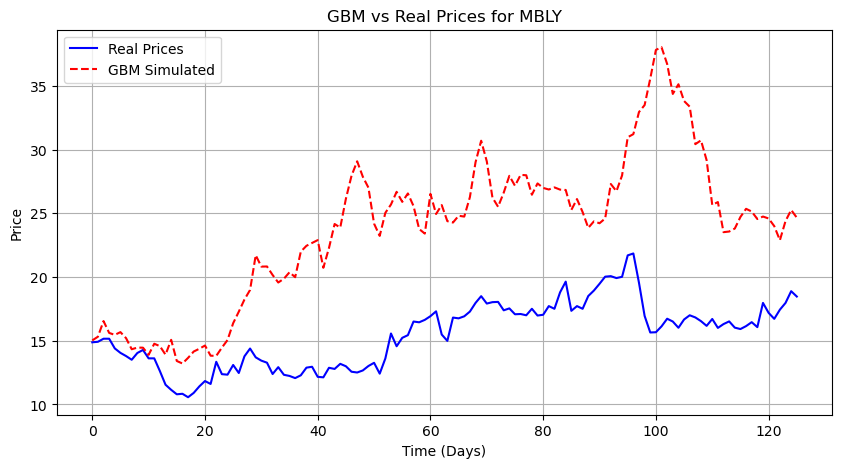

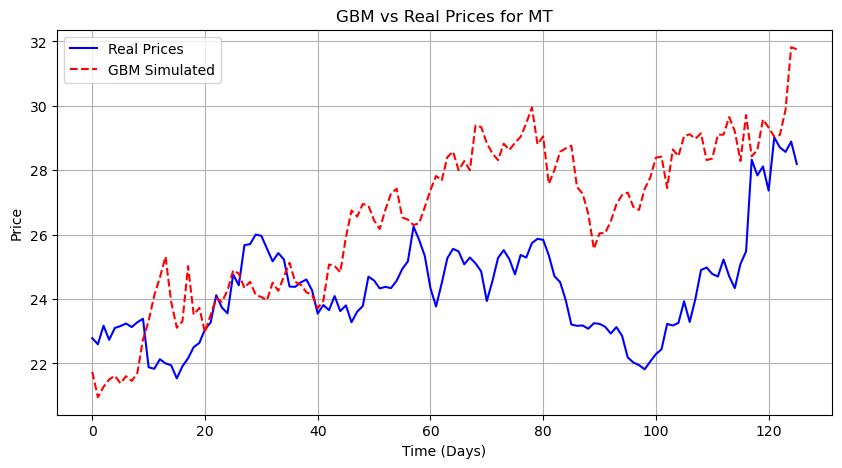

Error fetching option chain: 'str' object has no attribute 'empty'
No options available for SAIL on 2025-02-28 00:00:00


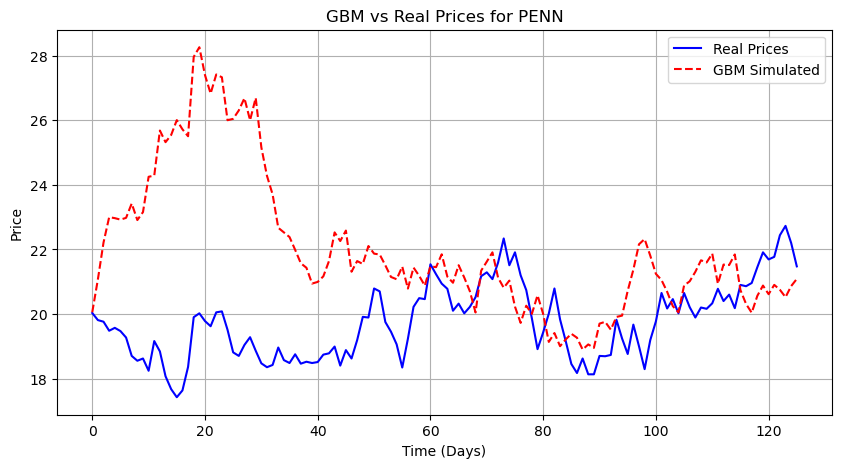

Error fetching option chain: 'puts'
No options available for DB on 2025-02-28 00:00:00
Error fetching option chain: 'puts'
No options available for MP on 2025-02-28 00:00:00
Error fetching option chain: 'puts'
No options available for MGNI on 2025-02-28 00:00:00
Error fetching option chain: 'puts'
No options available for NVST on 2025-02-28 00:00:00
Error fetching option chain: 'puts'
No options available for RSI on 2025-02-28 00:00:00
Error fetching option chain: 'puts'
No options available for GRND on 2025-02-28 00:00:00
Error fetching option chain: 'puts'
No options available for WEAV on 2025-02-28 00:00:00
Error fetching option chain: 'str' object has no attribute 'empty'
No options available for EPOL on 2025-02-28 00:00:00
Error fetching option chain: 'puts'
No options available for DAN on 2025-02-28 00:00:00
Error fetching option chain: 'puts'
No options available for MAG on 2025-02-28 00:00:00
Error fetching option chain: 'puts'
No options available for CAE on 2025-02-28 00:00:0

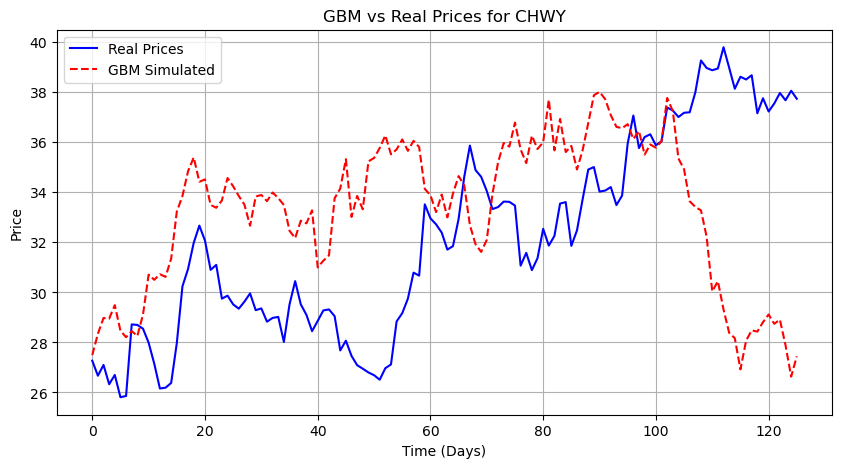

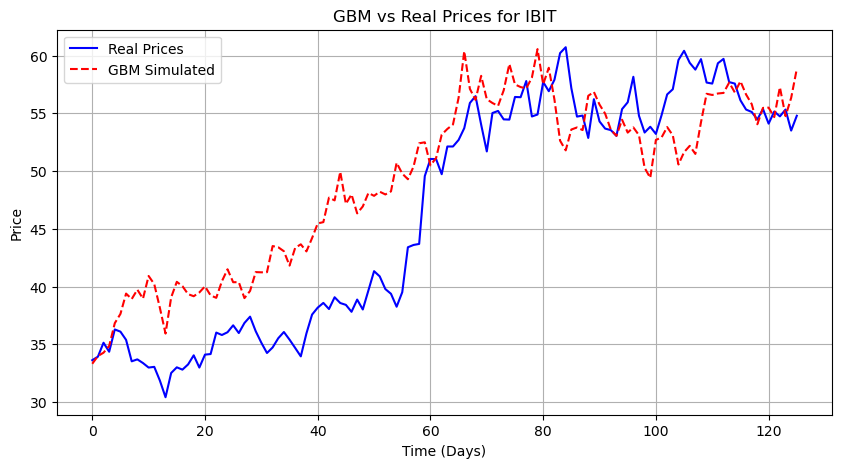

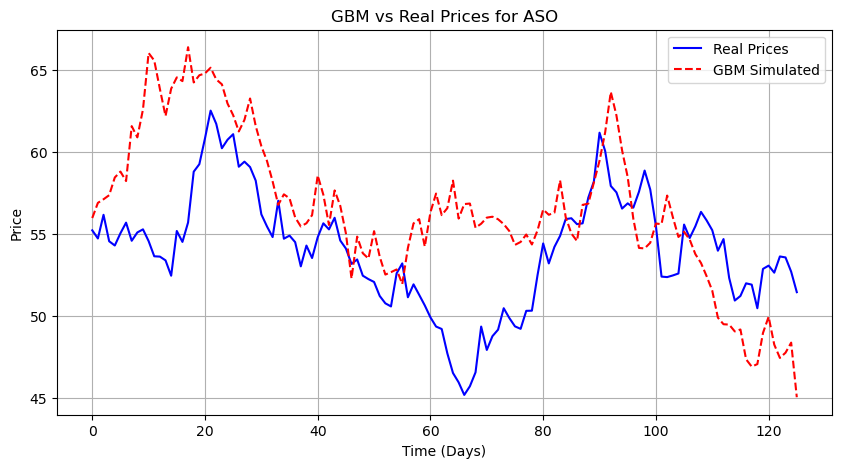

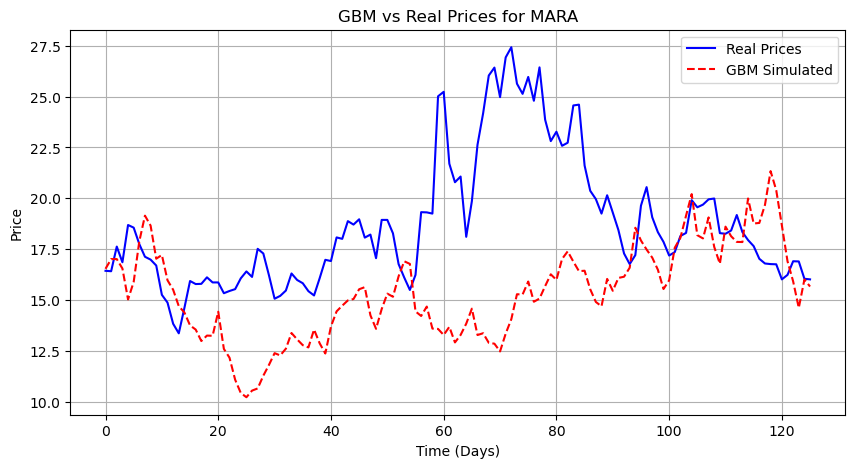

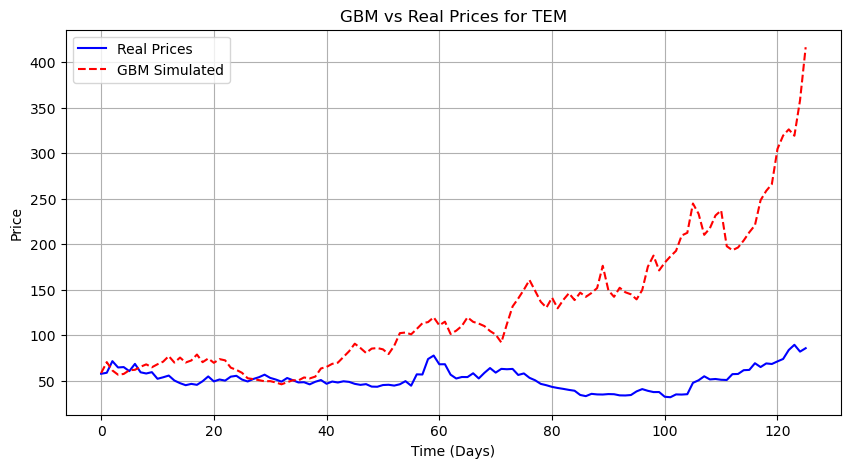

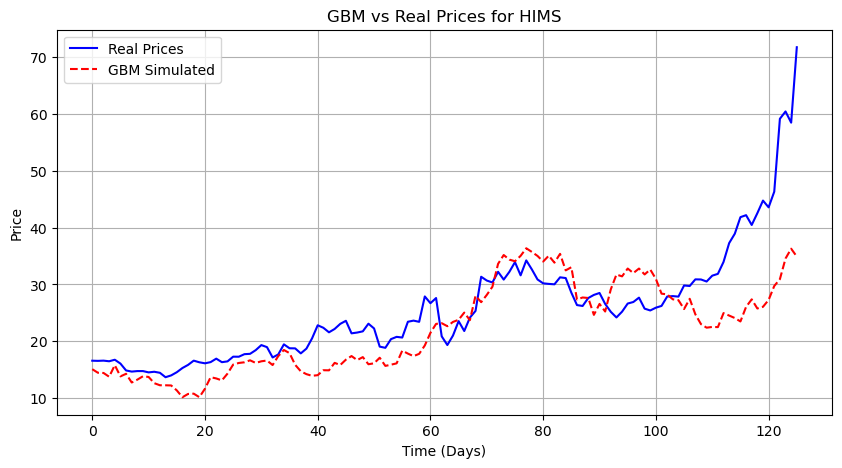

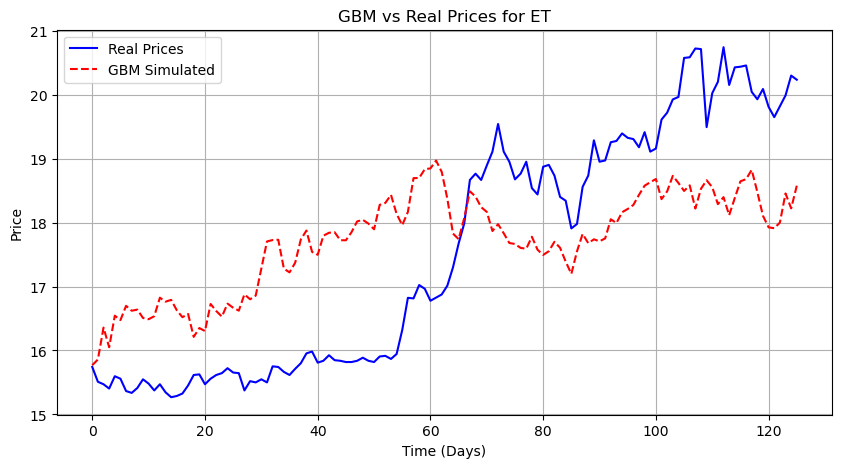

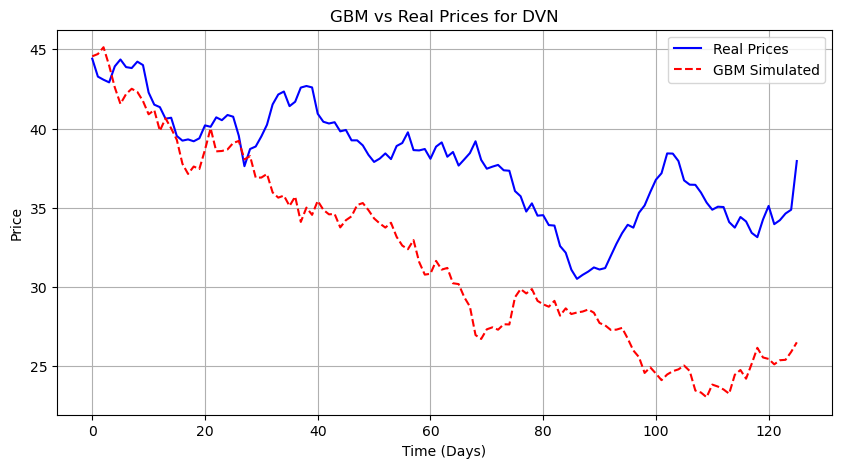

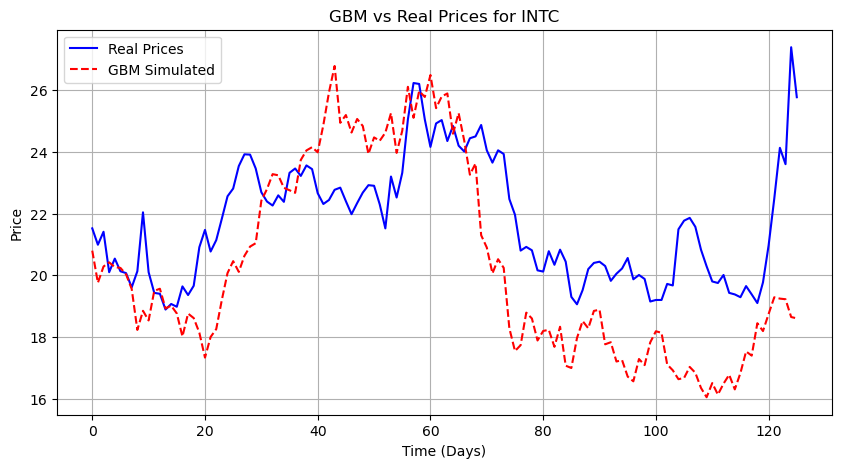

Error fetching option chain: 'puts'
No options available for SPLG on 2025-02-28 00:00:00


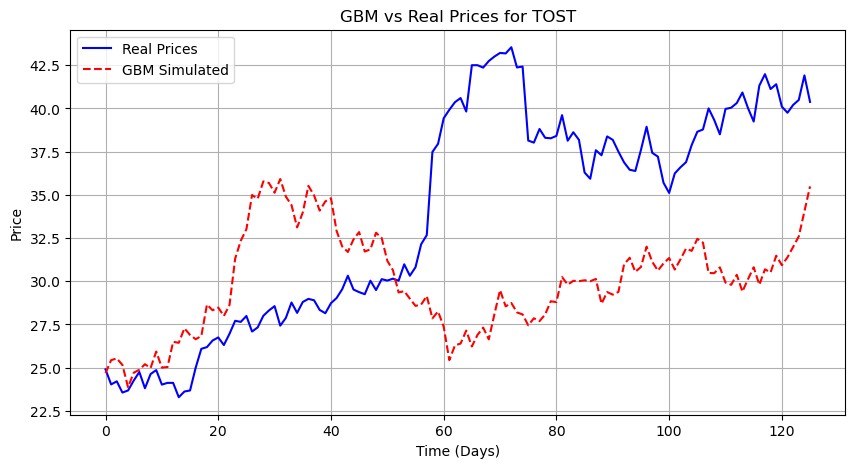

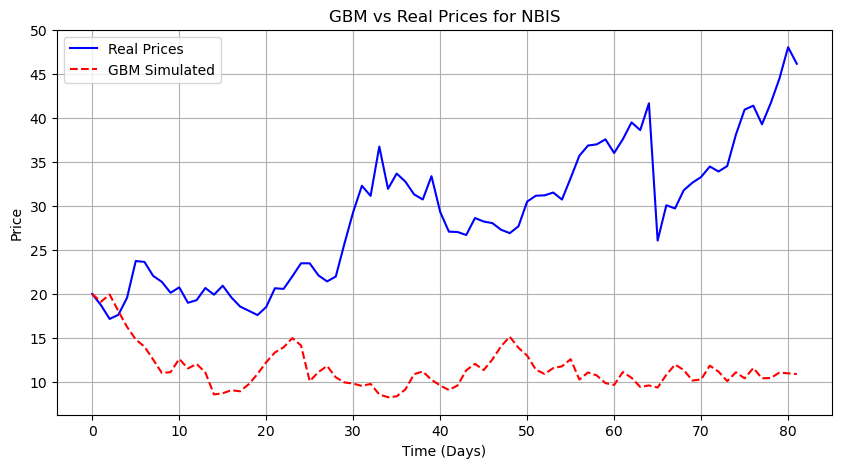

In [59]:
# Analyze a bunch of stocks
# contracts = audit_csps(expiration_date = datetime(year=2025, month=2, day=21))

# Analyze one stock
contracts = audit_stocks( expiration_date=datetime(year=2025, month=2, day=28))

In [60]:

contracts = select_optimal_contract(contracts)
display(contracts)

,symbol,expiration_date,strike,lastPrice,change,percentChange,volume,openInterest,bid,ask,mid_price,ROI,current_price,final_price,profitability_likelihood,average_roi,sortino_ratio,score
85,HIMS,2025-02-28,57.0,2.32,-3.33,-58.938057,173.0,806.0,2.15,2.27,2.210,3.877193,71.740,77.516182,95.000000,3.604245,5.803075,0.988939
82,HIMS,2025-02-28,54.0,1.55,-2.65,-63.095240,90.0,253.0,1.40,1.89,1.645,3.046296,71.740,77.557259,99.000000,2.936495,7.902013,0.964781
106,TOST,2025-02-28,37.0,1.33,0.34,34.343437,3.0,54.0,1.27,1.32,1.295,3.500000,40.375,41.210841,92.333333,3.261566,13.135150,0.964191
84,HIMS,2025-02-28,56.0,1.96,-3.04,-60.800000,93.0,241.0,1.82,2.09,1.955,3.491071,71.740,76.466938,96.000000,3.144158,2.919744,0.941421
105,TOST,2025-02-28,36.0,0.99,0.24,32.000000,15.0,56.0,0.96,1.00,0.980,2.722222,40.375,41.419105,97.000000,2.665803,12.542180,0.936167
83,HIMS,2025-02-28,55.0,1.71,-2.89,-62.826088,4225.0,2369.0,1.72,1.80,1.760,3.200000,71.740,77.529252,96.333333,2.869360,3.771133,0.920378
81,HIMS,2025-02-28,53.0,1.54,-2.16,-58.378384,90.0,83.0,1.25,1.38,1.315,2.481132,71.740,77.195181,97.666667,2.277349,2.344486,0.851409
80,HIMS,2025-02-28,52.0,1.39,-1.87,-57.361965,139.0,651.0,1.06,1.19,1.125,2.163462,71.740,76.097299,97.666667,2.036775,3.289971,0.824004
104,TOST,2025-02-28,35.0,0.70,0.15,27.272724,24.0,224.0,0.65,0.74,0.695,1.985714,40.375,41.327547,99.666667,1.981027,0.000000,0.808376
79,HIMS,2025-02-28,51.0,1.00,-2.00,-62.893085,1071.0,116.0,0.90,1.12,1.010,1.980392,71.740,77.647593,99.333333,1.951005,0.000000,0.803646


In [ ]:
# Archive

# def audit_csps(expiration_date: datetime):
#     # t-bill 3-month rate: 4.19% and inflation: 2.9%, scaled to daily compounding
#     daily_risk_free_rate = (1 + 0.0419) ** (1/252) - 1  # No inflation adjustment

#     # function hyperparameters
#     simulation_attempts = 300
#     optimizer_training_period = "6mo"
#     bin_length = 18
#     days_to_expiration = np.busday_count(datetime.today().date(), expiration_date.date())

#     all_options = []  
    
#     candidates = screen_stocks()['ticker'].to_list()
#     candidates.extend(our_picks)    

#     print(f"Consider {len(candidates)} stocks")

#     for symbol in candidates:
#         option_chain = get_option_chain(api_key=api_key, secret_key=secret_key, ticker=symbol, expiration_date=expiration_date)

#         if option_chain is None or option_chain.empty:
#             continue

#         price = get_current_stock_price(symbol)
#         optimized_mu, optimized_sigma = optimize_gbm(symbol=symbol, training_period=optimizer_training_period, bin_length=bin_length)
#         optimized_sigma = fit_garch(symbol=symbol, period=optimizer_training_period)

#         gbm_vs_real_graph(symbol=symbol, mu=optimized_mu, sigma=optimized_sigma, period=optimizer_training_period)

#         put_chain_copy = option_chain.copy()

#         for index, contract in put_chain_copy.iterrows():
#             strike_price = contract['strike_price']
#             mid_price = contract['mid_price']
#             simulated_returns = []
#             simulated_final_prices = []
#             profitable_count = 0

#             # Run simulations
#             for _ in range(simulation_attempts):
#                 prices = gbm(
#                     s0=price, mu=optimized_mu, sigma=optimized_sigma, 
#                     deltaT=days_to_expiration, 
#                     dt=1
#                 )
#                 final_price = prices[-1]
#                 # option expires worthless (or at-the-money), seller keeps premium.
#                 if final_price >= strike_price:
#                     profitable_count += 1
#                     net_return = (mid_price / strike_price) * 100
#                 else:
#                     # assigned, the net return is: premium - (loss from assignment)
#                     net_return = ((mid_price - (strike_price - final_price)) / strike_price) * 100

#                 simulated_returns.append(net_return)
#                 simulated_final_prices.append(prices[-1])

#             profitability_chance = (profitable_count / simulation_attempts) * 100
#             percent_return = (mid_price / strike_price) * 100  
#             avg_return = np.mean(simulated_returns)
#             avg_price = np.mean(simulated_final_prices)
            
#             risk_free_return = daily_risk_free_rate * days_to_expiration
#             # Downside returns: only include simulated returns that are below the target.
#             downside_returns = [r for r in simulated_returns if r < risk_free_return]
#             if len(downside_returns) > 1:
#                 downside_std = np.std(downside_returns, ddof=1)
#             else:
#                 downside_std = 0

#             # Annualize the ratio (using sqrt(252/days_to_expiration))
#             if downside_std != 0:
#                 sortino_ratio = ((avg_return - risk_free_return) / downside_std) * np.sqrt(252 / days_to_expiration)
#             else:
#                 sortino_ratio = 0

#             put_chain_copy.at[index, 'mid'] = mid_price
#             put_chain_copy.at[index, 'current_price'] = price
#             put_chain_copy.at[index, 'final_price'] = avg_price
#             put_chain_copy.at[index, 'profitability_likelihood'] = profitability_chance
#             put_chain_copy.at[index, 'return_percent'] = percent_return
#             put_chain_copy.at[index, 'average_return'] = avg_return
#             put_chain_copy.at[index, 'sortino_ratio'] = sortino_ratio

#         all_options.append(put_chain_copy)

#     # Concatenate all DataFrames in the list once at the end
#     result_df = pd.concat(all_options, ignore_index=True)

#     # Drop unnecessary columns and reorder at the end
#     result_df.drop(columns=['inTheMoney','contractSymbol','currency','contractSize', 'lastTradeDate', 'impliedVolatility'], errors='ignore', inplace=True)

#     return result_df



# def get_open_interest(api_key: str, secret_key: str, option_symbol: str):
#     """Fetches open interest for a given option contract using Alpaca's Trading API."""
#     url = f"https://paper-api.alpaca.markets/v2/options/contracts/{option_symbol}"
#     headers = {
#         "accept": "application/json",
#         "APCA-API-KEY-ID": api_key,
#         "APCA-API-SECRET-KEY": secret_key,
#     }

#     try:
#         response = requests.get(url, headers=headers)
#         response.raise_for_status()
#         data = response.json()
#         return data.get("open_interest")  # Extract OI if available
#     except requests.exceptions.RequestException as e:
#         print(f"Error fetching open interest for {option_symbol}: {e}")
#         return None

# def get_option_chain(api_key: str, secret_key: str, ticker: str, expiration_date: datetime):
#     expiration_str = expiration_date.strftime("%Y-%m-%d")  
#     data = yf.download(tickers=ticker, period="6mo", interval="1d", progress=False)

#     if len(data) == 0:
#         return None
    
#     url = f"https://data.alpaca.markets/v1beta1/options/snapshots/{ticker}?feed=indicative&limit=100&expiration_date={expiration_str}"
#     headers = {
#         "accept": "application/json",
#         "APCA-API-KEY-ID": api_key,
#         "APCA-API-SECRET-KEY": secret_key,
#     }

#     try:
#         response = requests.get(url, headers=headers)
#         response.raise_for_status()
#         data = response.json()
#         option_chain = data.get("snapshots", {})

#         parsed_data = []
#         for symbol, details in option_chain.items():
#             expiration_start = len(symbol) - 15
#             option_type = "Call" if symbol[expiration_start+6] == "C" else "Put"
#             strike_price = int(symbol[expiration_start+7:]) / 1000  

#             greeks = details.get("greeks", {}) or {}
#             latest_quote = details.get("latestQuote", {})

#             returned = ((latest_quote.get("ap") + latest_quote.get("bp") / 2) / strike_price) * 100
        
            
#             # if latest_quote.get("ap") == 0 or latest_quote.get("bp") == 0:
#             #     continue
            
#             # if (((latest_quote.get("ap") - latest_quote.get("bp")) / latest_quote.get("bp")) * 100 > 40) or greeks.get("delta") is None or returned < 0.3 or returned > 3.5:
#             #     continue
#             # print("after prices")

#             open_interest = get_open_interest(api_key, secret_key, symbol)
#             open_interest = int(open_interest) if open_interest is not None else 0

#             # if (open_interest < 40):
#             #     continue
            
#             parsed_data.append({
#                 "symbol": ticker,
#                 "expiration_date": expiration_str,  
#                 "option_type": option_type,
#                 "delta": greeks.get("delta"),
#                 "gamma": greeks.get("gamma"),
#                 "rho": greeks.get("rho"),
#                 "theta": greeks.get("theta"),
#                 "vega": greeks.get("vega"),
#                 "implied_volatility": details.get("impliedVolatility"),
#                 "ask_price": latest_quote.get("ap"),
#                 "ask_size": latest_quote.get("as"),
#                 "bid_price": latest_quote.get("bp"),
#                 "bid_size": latest_quote.get("bs"),
#                 "mid_price": (latest_quote.get("bp") + latest_quote.get("ap")) / 2,
#                 "open_interest": open_interest,
#                 "strike_price": strike_price 

#             })

#         print("parsed", parsed_data)
#         df = pd.DataFrame(parsed_data)
#         print("df\n", df)
#         if len(df) == 0: 
#             return None
        
#         df = df[(df['option_type'] == 'Put')]
        
#         return df


    
#     except requests.exceptions.RequestException as e:
#         print(f"Error fetching option chain: {e}")
#         return None


# def get_rolling_price_change_avg(ticker: str, days: int):
#     try:
#         end_date = datetime.now()
#         start_date = end_date - timedelta(days=days+10)
        
#         data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
#         if data.empty:
#             return None
        
#         data = data.sort_index()
#         current_price = get_current_stock_price(ticker)

#         data['Price_Change'] = ((current_price - data['Close'].shift(1)) / data['Close'].shift(1)) * 100

#         rolling_avg = data['Price_Change'].rolling(window=min(days, len(data))).mean().iloc[-1]

#         return rolling_avg
    
#     except Exception as e:
#         print(f"Error occurred for ticker {ticker}: {e}")
#         return None, None


# def aobjective(params, real_prices, s0):
#     """Objective function for optimization."""
#     mu, sigma = params  # Unpack parameters
#     gbm_prices = gbm(s0, mu, sigma, deltaT=len(real_prices), dt=1)
#     return mean_squared_error(real_prices, gbm_prices)

# def aoptimize_gbm(symbol: str, training_period: str, bin_length: int):
#     """
#     Optimize μ and σ over multiple time bins, weighting recent periods more.
#     """
#     # Fetch real stock data (past 5 years)
#     stock_data = yf.download(symbol, period=training_period, interval="1d")
#     real_prices = stock_data["Close"].dropna().values

#     num_bins = len(real_prices) // bin_length
#     weights = np.linspace(1, 2, num_bins)  # Increasing weights for recent bins

#     mu_values, sigma_values, mses = [], [], []

#     for i in range(num_bins):
#         bin_prices = real_prices[i * bin_length : (i + 1) * bin_length]
#         s0 = bin_prices[0]

#         bounds = [(-0.3, 0.3), (0.001, 0.35)]

#         result = differential_evolution(objective, bounds, args=(bin_prices, s0))
#         best_mu, best_sigma = result.x
#         best_mse = result.fun

#         mu_values.append(best_mu)
#         sigma_values.append(best_sigma)
#         mses.append(best_mse)

#     weight_sum = np.sum(weights)
#     avg_mu = np.sum(np.array(mu_values) * weights) / weight_sum
#     avg_sigma = np.sum(np.array(sigma_values) * weights) / weight_sum

#     print(f"\nFinal Weighted Averages: μ = {avg_mu:.4f}, σ = {avg_sigma:.4f}")

#     return avg_mu, avg_sigma



    # def filter_stocks(rolling_change_period): 
    # filtered_stocks = set()
    # stocks = screen_stocks()

    # for index, stock in stocks.iterrows():
    #     try:
    #         today_change, rolling_avg = get_rolling_price_change_avg(stock['ticker'], days=rolling_change_period)
    #         current_price = get_current_stock_price(stock['ticker'])

    #         # Skip if any value is None
    #         if None in (today_change, rolling_avg, current_price):
    #             print(f"Skipping {stock['ticker']} due to missing data.")
    #             continue

    #         # Apply filtering conditions
    #         if (rolling_avg > 0.00): 
    #             filtered_stocks.add(stock['ticker'])

    #     except Exception as e:
    #         print(f"Skipping {stock['ticker']} due to error: {e}")
    #         continue
    
    # return filtered_stocks

    #def ORIGINAL_LOGIC_FOR _AUDITING_OPTIONS()
    # simulation_attempts = 200
    # optimizer_training_period = "2y"
    # bin_length = 20
    # rolling_change_period = 15
    # expiration_date = datetime(year=2025, month=2, day=14) 
    # all_options = pd.DataFrame(columns=['symbol', 'expiration_date', 'option_type', 'strike_price', 'delta', 'gamma', 'rho', 'theta', 'vega', 'implied_volatility', 'ask_price', 'ask_size', 'bid_price', 'bid_size'])
    # candidates = ["AAPL", "AMD"]
    # # filter_stocks(rolling_change_period=rolling_change_period)

    # # t-bill 3-month rate: 4.19%, inflation rate: 2.9% -> scaled to weekly
    # risk_free_rate = (((1 + 0.0419) / (1 + 0.029)) ** (1/52) - 1) * 100

    # print(candidates)

    # for symbol in candidates:
    #     option_chain = get_option_chain(api_key=api_key, secret_key=secret_key, ticker=symbol, expiration_date=expiration_date)
    #     put_chain = option_chain[(option_chain['option_type'] == 'Put') & (option_chain['rho'].notna())].sort_values(by='strike_price', ascending=True)

    #     if option_chain is None or option_chain.empty:
    #         continue 

    #     price = get_current_stock_price(symbol)
    #     optimized_mu, optimized_sigma = optimize_gbm(symbol=symbol, training_period=optimizer_training_period, bin_length=bin_length)

    #     profitability_chances = []
    #     percent_returns = []

    #     for index, contract in put_chain.iterrows():
    #         count = 0
    #         strike_price = contract['strike_price']

    #         for i in range(simulation_attempts):
    #             prices = gbm(s0=price, mu=optimized_mu, sigma=optimized_sigma, 
    #                 deltaT=np.busday_count(datetime.today().date(), datetime.strptime(contract['expiration_date'], "%Y-%m-%d").date()), dt=1)  
    #             if prices[-1] > strike_price:
    #                 count += 1
    #         profitability_chance = (count / simulation_attempts) * 100
    #         profit = (contract['bid_price']*contract['bid_size'] + contract['ask_price']*contract['ask_size']) / (contract['ask_size'] + contract['bid_size'])
    #         percent_return = (profit / (strike_price)) * 100

    #         profitability_chances.append(profitability_chance)
    #         percent_returns.append(percent_return)
    #     put_chain['profitability_percent'] = profitability_chances
    #     put_chain['percent_return'] = percent_returns
    #     put_chain['expected_value'] = put_chain['profitability_percent'] * put_chain['percent_return']
    #     put_chain['current_price'] = price
    #     if put_chain['percent_return'].std() != 0:
    #         put_chain['sortino_ratio'] = (put_chain['percent_return'] - risk_free_rate) / put_chain['percent_return'].std()
    #     else:
    #         put_chain['sortino_ratio'] = 0  # Avoid division by zero
    #     all_options = pd.concat([all_options, put_chain], ignore_index=True, copy=False)


# def gbm_vs_real_graph(symbol, mu, sigma, period):
#     stock_data = yf.download(symbol, period=period, interval="1d")
#     real_prices = stock_data["Close"].dropna().values
#     time_steps = np.arange(len(real_prices))


#     gbm_path = gbm(s0 = real_prices[0], mu=mu, sigma=sigma, deltaT=len(real_prices), dt=1)
#     plt.figure(figsize=(10, 5))
#     plt.plot(time_steps, real_prices, label="Real Prices", color="blue")
#     plt.plot(time_steps, gbm_path, label="GBM Simulated", linestyle="dashed", color="red")
    
#     plt.xlabel("Time (Days)")
#     plt.ylabel("Price")
#     plt.title(f"GBM vs Real Prices for {symbol}")
#     plt.legend()
#     plt.grid()
#     plt.show()

# def multithread_optimize_bin(bin_prices, bin_size, weights, i):
#     s0 = bin_prices[0]

#     # Define the bounds for optimization
#     bounds = [(-0.3, 0.3), (0.001, 0.30)]

#     # Run the optimizer for the bin
#     result = differential_evolution(objective, bounds, args=(bin_prices, s0))
#     best_mu, best_sigma = result.x
#     best_mse = result.fun

#     print(f"Bin {i+1}: μ = {best_mu:.4f}, σ = {best_sigma:.4f}, MSE = {best_mse:.4f}")
#     return best_mu, best_sigma, best_mse

# def multithread_optimize_gbm(symbol): 
    # """
    # Optimize μ and σ over multiple time bins, weighting recent periods more.
    # """
    # # Fetch real stock data (past 2 years)
    # stock_data = yf.download(symbol, period="2y", interval="1d")
    # real_prices = stock_data["Close"].dropna().values

    # # Split into bins of 20 trading days
    # bin_size = 20
    # num_bins = len(real_prices) // bin_size
    # weights = np.linspace(1, 2, num_bins)  # Increasing weights for recent bins

    # # Initialize containers for results
    # mu_values, sigma_values, mses = [], [], []

    # # Use concurrent.futures for parallel processing of bins
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #     futures = []
    #     for i in range(num_bins):
    #         bin_prices = real_prices[i * bin_size : (i + 1) * bin_size]
    #         futures.append(executor.submit(optimize_bin, bin_prices, bin_size, weights, i))
        
    #     for future in concurrent.futures.as_completed(futures):
    #         best_mu, best_sigma, best_mse = future.result()
    #         mu_values.append(best_mu)
    #         sigma_values.append(best_sigma)
    #         mses.append(best_mse)

    # # Compute weighted averages
    # weight_sum = np.sum(weights)
    # avg_mu = np.sum(np.array(mu_values) * weights) / weight_sum
    # avg_sigma = np.sum(np.array(sigma_values) * weights) / weight_sum

    # print(f"\nFinal Weighted Averages: μ = {avg_mu:.4f}, σ = {avg_sigma:.4f}")

    # return avg_mu, avg_sigma

# NASDAQ = pd.read_csv('Indexes/NASDAQ.csv')
# DOWJ = pd.read_csv('Indexes/DOWJ.csv')
# SP = pd.read_csv('Indexes/S&P500.csv')

# def clean_data(df):
#     df = df[['Company', 'Symbol']]
#     df = pd.DataFrame(df).dropna()
#     return df

# NASDAQ = clean_data(NASDAQ)
# DOWJ = clean_data(DOWJ)
# SP = clean_data(SP)